In [1]:
%load_ext autoreload
%autoreload 2

### Dataset

In [2]:
import numpy
import torch
import torchvision
import torchvision.transforms.v2

transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

train = torchvision.datasets.CIFAR10('cifar-10', transform = transform, train = True, download = False)
test = torchvision.datasets.CIFAR10('cifar-10', transform = transform, train = False, download = False)

train_images = numpy.array([ numpy.array(item[0]) for item in train ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ numpy.array(item[0]) for item in test ])
test_labels = numpy.array([ item[1] for item in test ])

train_images.shape, test_images.shape

((50000, 3, 32, 32), (10000, 3, 32, 32))

### Features

In [12]:
import os
import tqdm
import cvtda.utils
import cvtda.topology

def make_features(
    train: numpy.ndarray,
    test: numpy.ndarray,
    name: str,
    binarizer,
    filtration
):
    if os.path.exists(f"6/{name}/test_features.npy"):
        return
    
    if binarizer is not None:
        train = binarizer.fit_transform(train)
        test = binarizer.transform(test)
        
    if filtration is not None:
        train = filtration.fit_transform(train)
        test = filtration.transform(test)

    filtrations_to_diagrams = cvtda.topology.FiltrationsToDiagrams(homology_dimensions = [ 0, 1, 2 ])
    train = filtrations_to_diagrams.fit_transform(train)
    test = filtrations_to_diagrams.transform(test)
    print(train.shape, test.shape)

    n_bins = (64 if len(train) < 512 else 128)
    digrams_to_features = cvtda.topology.DiagramsToFeatures(batch_size = 625, n_bins = n_bins)
    train = digrams_to_features.fit_transform(train)
    test = digrams_to_features.transform(test)
    print(train.shape, test.shape)

    ok_features = []
    for idx in tqdm.trange(train.shape[1]):
        if numpy.std(train[:, idx]) > 1e-6:
            ok_features.append(idx)
    train = train[:, ok_features]
    test = test[:, ok_features]
    print(train.shape, test.shape)

    duplicates_remover = cvtda.utils.DuplicateFeaturesRemover()
    train = duplicates_remover.fit_transform(train)
    test = duplicates_remover.transform(test)
    print(train.shape, test.shape)

    os.makedirs(f"6/{name}", exist_ok = True)
    numpy.save(f"6/{name}/train_features.npy", train)
    numpy.save(f"6/{name}/test_features.npy", test)

In [ ]:
make_features(train_images, test_images, "raw", binarizer = None, filtration = None)

Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [01:39<00:00, 501.99it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:20<00:00, 497.29it/s]


Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:06<00:00,  2.20s/it]


Fitting complete


Batch:   0%|          | 0/80 [00:00<?, ?it/s]d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 48%|████▊     | 188/390 [00:00<00:00, 1861.45it/s]d:\Programs\Programming\Python\lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
d:\Programs\Programming\Python\lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
100%|██████████| 271/271 [00:00<00:00, 906.36it/s, partition_by=32105, num_features=2, duplicates=80]


Found 81 duplicates
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [02:06<00:00, 395.07it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:24<00:00, 402.72it/s]


Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


Fitting complete


100%|██████████| 390/390 [00:00<00:00, 2252.62it/s]


In [13]:
import itertools
import gtda.images

greyscale_to_filtrations = cvtda.topology.GreyscaleToFiltrations(
    binarizer_threshold = 0.4,
    height_filtration_directions = list(itertools.product([ 0, 1, -1 ], [ 0, 1, -1 ], [ 0, 1, -1 ]))[1:],
    radial_filtration_centers = list(itertools.product([ 0, 1, 2 ], [ 3, 8, 13, 18, 23, 28 ], [ 3, 8, 13, 18, 23, 28 ]))
)
for i, filtration in enumerate(greyscale_to_filtrations.filtrations_):
    print(f"{i}/{len(greyscale_to_filtrations.filtrations_)}). {filtration}")
    make_features(
        train_images,
        test_images,
        f"{type(filtration).__name__}{i}",
        binarizer = gtda.images.Binarizer(threshold = 0.4),
        filtration = filtration
    )

0/139). HeightFiltration(direction=array([0, 0, 1]), n_jobs=-1)
1/139). HeightFiltration(direction=array([ 0,  0, -1]), n_jobs=-1)
2/139). HeightFiltration(direction=array([0, 1, 0]), n_jobs=-1)
3/139). HeightFiltration(direction=array([0, 1, 1]), n_jobs=-1)
4/139). HeightFiltration(direction=array([ 0,  1, -1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [01:50<00:00, 451.43it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:21<00:00, 459.33it/s]


(50000, 134, 3) (10000, 87, 3)
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Fitting complete


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Batch:  42%|████▎     | 34/80 [01:26<01:57,  2.55s/it]


KeyboardInterrupt: 

### Analyze features

In [4]:
import os

train_features = numpy.hstack([
    numpy.load(f"6/{folder}/train_features.npy")
    for folder in os.listdir("6")
])

test_features = numpy.hstack([
    numpy.load(f"6/{folder}/test_features.npy")
    for folder in os.listdir("6")
])

train_features.shape, test_features.shape

((50000, 1549), (10000, 1549))

In [6]:
train_features = numpy.minimum(train_features, 1e9)
test_features = numpy.minimum(test_features, 1e9)

In [7]:
import sklearn.preprocessing

selected_standard_scaler = sklearn.preprocessing.StandardScaler()
train_features = selected_standard_scaler.fit_transform(numpy.nan_to_num(train_features, 0))
test_features = selected_standard_scaler.transform(numpy.nan_to_num(test_features, 0))

train_features.shape, test_features.shape

((50000, 1549), (10000, 1549))

### StandardScaler

In [8]:
import cvtda.classification

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.2923, 'TOP-2 Accuracy': 0.4833, 'TOP-3 Accuracy': 0.6082, 'TOP-4 Accuracy': 0.7005, 'TOP-5 Accuracy': 0.7804, 'TOP-6 Accuracy': 0.8414, 'TOP-7 Accuracy': 0.8962, 'TOP-8 Accuracy': 0.9382, 'TOP-9 Accuracy': 0.973, 'AUC-ROC': 0.7418116666666665, 'Precision': 0.29193915774390566, 'Recall': 0.29229999999999995, 'F1-score': 0.29059171837731984}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.3641, 'TOP-2 Accuracy': 0.5547, 'TOP-3 Accuracy': 0.6767, 'TOP-4 Accuracy': 0.7623, 'TOP-5 Accuracy': 0.8336, 'TOP-6 Accuracy': 0.8868, 'TOP-7 Accuracy': 0.9245, 'TOP-8 Accuracy': 0.9567, 'TOP-9 Accuracy': 0.9798, 'AUC-ROC': 0.789944572222222, 'Precision': 0.3586030188588903, 'Recall': 0.3641, 'F1-score': 0.3590613877747502}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x0000023CCF812320>
Input to LazyLinear: 

100%|██████████| 25/25 [00:53<00:00,  2.14s/it, loss=1.05e+5, val_acc=0.38] 


{'classifier': 'NNClassifier', 'Accuracy': 0.3802, 'TOP-2 Accuracy': 0.5798, 'TOP-3 Accuracy': 0.701, 'TOP-4 Accuracy': 0.7799, 'TOP-5 Accuracy': 0.8433, 'TOP-6 Accuracy': 0.8904, 'TOP-7 Accuracy': 0.9313, 'TOP-8 Accuracy': 0.9614, 'TOP-9 Accuracy': 0.9839, 'AUC-ROC': 0.7915290500000001, 'Precision': 0.37627597093780685, 'Recall': 0.3802, 'F1-score': 0.3740607646896178}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.3569, 'TOP-2 Accuracy': 0.5579, 'TOP-3 Accuracy': 0.6867, 'TOP-4 Accuracy': 0.7751, 'TOP-5 Accuracy': 0.8428, 'TOP-6 Accuracy': 0.8956, 'TOP-7 Accuracy': 0.9367, 'TOP-8 Accuracy': 0.9658, 'TOP-9 Accuracy': 0.9865, 'AUC-ROC': 0.7962315999999999, 'Precision': 0.34909490189761855, 'Recall': 0.3569, 'F1-score': 0.3492913766958806}
Fitting <catboost.core.CatBoostClassifier object at 0x0000023CCF812230>
Learning rate set to 0.309284
0:

d:\Programs\Programming\Python\lib\site-packages\xgboost\core.py:158: UserWarning: [17:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


{'classifier': 'XGBClassifier', 'Accuracy': 0.3787, 'TOP-2 Accuracy': 0.5822, 'TOP-3 Accuracy': 0.7051, 'TOP-4 Accuracy': 0.7937, 'TOP-5 Accuracy': 0.8573, 'TOP-6 Accuracy': 0.9057, 'TOP-7 Accuracy': 0.9437, 'TOP-8 Accuracy': 0.9692, 'TOP-9 Accuracy': 0.9903, 'AUC-ROC': 0.8121246333333333, 'Precision': 0.3712828489495409, 'Recall': 0.3787, 'F1-score': 0.3724990198013474}


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.2923,0.4833,0.6082,0.7005,0.7804,0.8414,0.8962,0.9382,0.9730,0.741812,0.291939,0.2923,0.290592
1,RandomForestClassifier,0.3641,0.5547,0.6767,0.7623,0.8336,0.8868,0.9245,0.9567,0.9798,0.789945,0.358603,0.3641,0.359061
2,NNClassifier,0.3802,0.5798,0.7010,0.7799,0.8433,0.8904,0.9313,0.9614,0.9839,0.791529,0.376276,0.3802,0.374061
3,HistGradientBoostingClassifier,0.3569,0.5579,0.6867,0.7751,0.8428,0.8956,0.9367,0.9658,0.9865,0.796232,0.349095,0.3569,0.349291
4,CatBoostClassifier,0.4141,0.6131,0.7363,0.8171,0.8765,0.9206,0.9521,0.9769,0.9931,0.833373,0.409941,0.4141,0.411131
5,XGBClassifier,0.3787,0.5822,0.7051,0.7937,0.8573,0.9057,0.9437,0.9692,0.9903,0.812125,0.371283,0.3787,0.372499


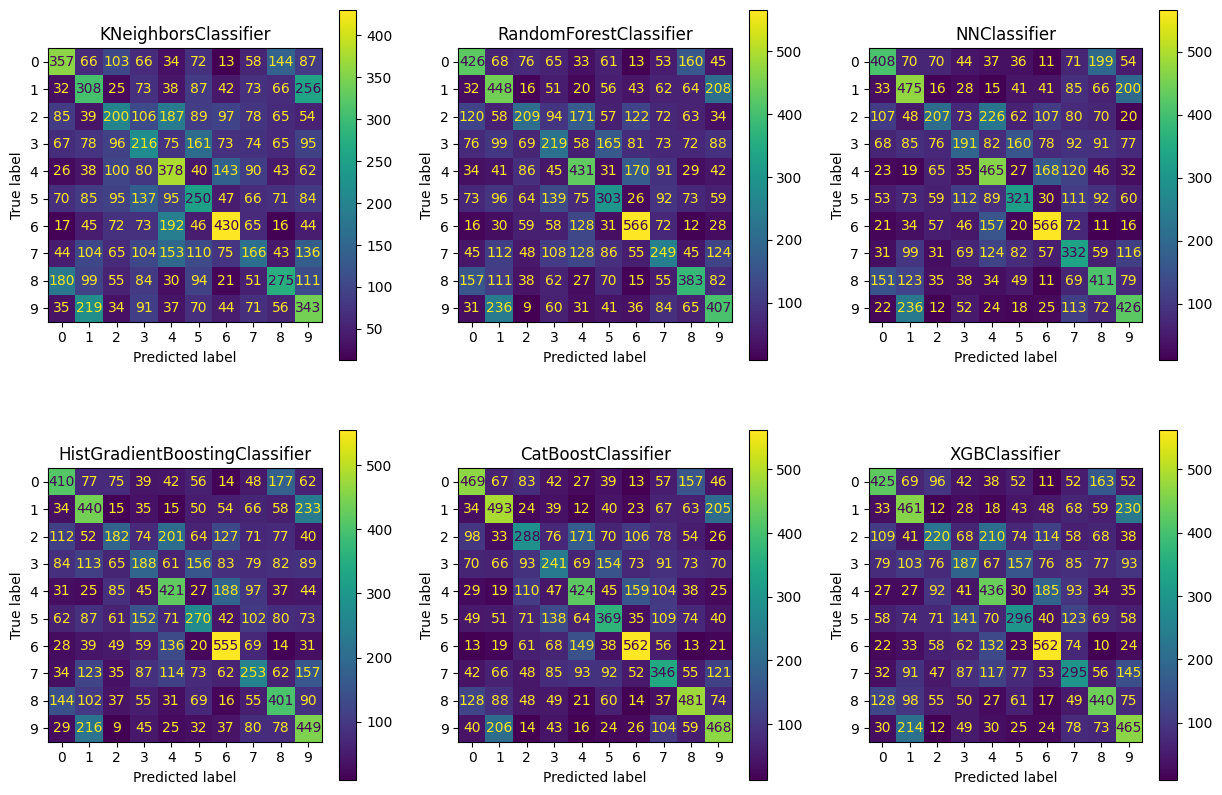

In [9]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

### InformationValueFeatureSelector

Fitting the information value feature selector


information values: 100%|██████████| 1549/1549 [00:21<00:00, 73.15it/s] 


Fitting complete


((50000, 757), (10000, 757))

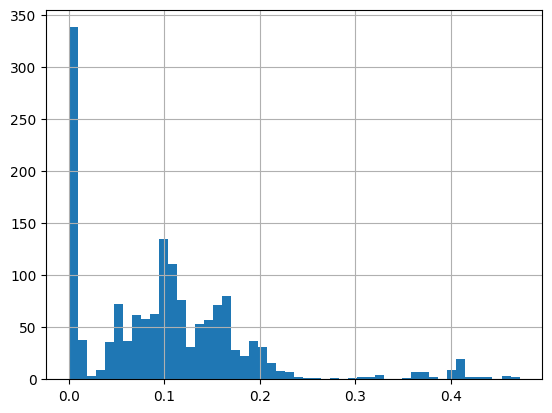

In [10]:
import cvtda.classification

feature_selector = cvtda.classification.InformationValueFeatureSelector(threshold = 0.1, bins = 50)

train_features = feature_selector.fit_transform(train_features, train_labels)
test_features = feature_selector.transform(test_features)

feature_selector.hist()

train_features.shape, test_features.shape

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3116, 'TOP-2 Accuracy': 0.4996, 'TOP-3 Accuracy': 0.6277, 'TOP-4 Accuracy': 0.7259, 'TOP-5 Accuracy': 0.7994, 'TOP-6 Accuracy': 0.8559, 'TOP-7 Accuracy': 0.9008, 'TOP-8 Accuracy': 0.9413, 'TOP-9 Accuracy': 0.9756, 'AUC-ROC': 0.7547549499999999, 'Precision': 0.30743635081140336, 'Recall': 0.31160000000000004, 'F1-score': 0.30703855803561825}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.3628, 'TOP-2 Accuracy': 0.5582, 'TOP-3 Accuracy': 0.6773, 'TOP-4 Accuracy': 0.7673, 'TOP-5 Accuracy': 0.833, 'TOP-6 Accuracy': 0.886, 'TOP-7 Accuracy': 0.9262, 'TOP-8 Accuracy': 0.9593, 'TOP-9 Accuracy': 0.984, 'AUC-ROC': 0.7902257277777778, 'Precision': 0.35682748401282993, 'Recall': 0.36279999999999996, 'F1-score': 0.35779226214358645}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x0000023CCFC9F340>
Input t

100%|██████████| 25/25 [00:44<00:00,  1.79s/it, loss=1.05e+5, val_acc=0.376]


{'classifier': 'NNClassifier', 'Accuracy': 0.3755, 'TOP-2 Accuracy': 0.569, 'TOP-3 Accuracy': 0.6916, 'TOP-4 Accuracy': 0.774, 'TOP-5 Accuracy': 0.8353, 'TOP-6 Accuracy': 0.887, 'TOP-7 Accuracy': 0.9261, 'TOP-8 Accuracy': 0.9582, 'TOP-9 Accuracy': 0.981, 'AUC-ROC': 0.7850915055555556, 'Precision': 0.36982527581028746, 'Recall': 0.3755, 'F1-score': 0.367127843168081}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.3542, 'TOP-2 Accuracy': 0.5516, 'TOP-3 Accuracy': 0.6755, 'TOP-4 Accuracy': 0.7666, 'TOP-5 Accuracy': 0.8378, 'TOP-6 Accuracy': 0.8898, 'TOP-7 Accuracy': 0.932, 'TOP-8 Accuracy': 0.9651, 'TOP-9 Accuracy': 0.9867, 'AUC-ROC': 0.7911132666666666, 'Precision': 0.34682220769552385, 'Recall': 0.3542, 'F1-score': 0.3471695157813507}
Fitting <catboost.core.CatBoostClassifier object at 0x0000023CCFEAC700>
Learning rate set to 0.309284
0:	lear

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3116,0.4996,0.6277,0.7259,0.7994,0.8559,0.9008,0.9413,0.9756,0.754755,0.307436,0.3116,0.307039
1,RandomForestClassifier,0.3628,0.5582,0.6773,0.7673,0.8330,0.8860,0.9262,0.9593,0.9840,0.790226,0.356827,0.3628,0.357792
2,NNClassifier,0.3755,0.5690,0.6916,0.7740,0.8353,0.8870,0.9261,0.9582,0.9810,0.785092,0.369825,0.3755,0.367128
3,HistGradientBoostingClassifier,0.3542,0.5516,0.6755,0.7666,0.8378,0.8898,0.9320,0.9651,0.9867,0.791113,0.346822,0.3542,0.347170
4,CatBoostClassifier,0.4024,0.6093,0.7294,0.8112,0.8719,0.9176,0.9517,0.9743,0.9904,0.828507,0.397191,0.4024,0.398836
5,XGBClassifier,0.3683,0.5707,0.6940,0.7876,0.8530,0.9032,0.9404,0.9700,0.9892,0.806546,0.361638,0.3683,0.362732


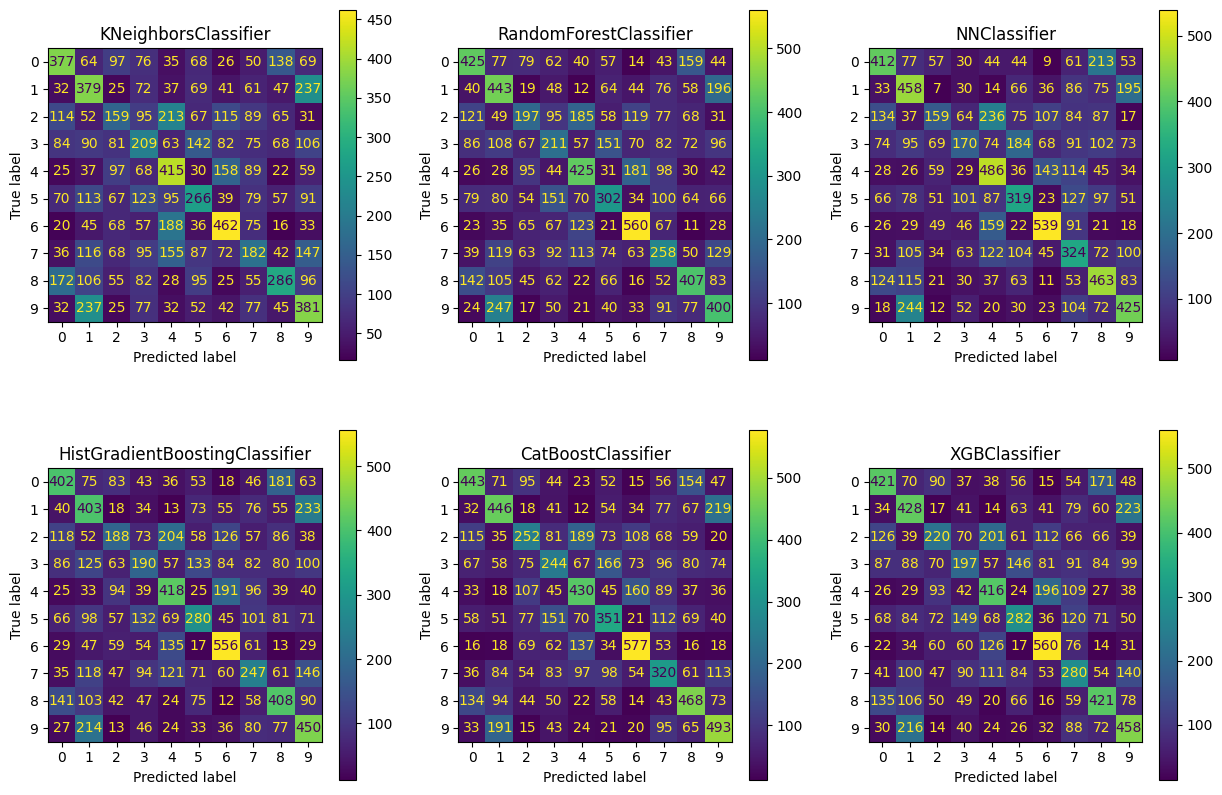

In [11]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

### CorrelationSelector

Fitting the correlations feature selector
Fitting complete


((50000, 481), (10000, 481))

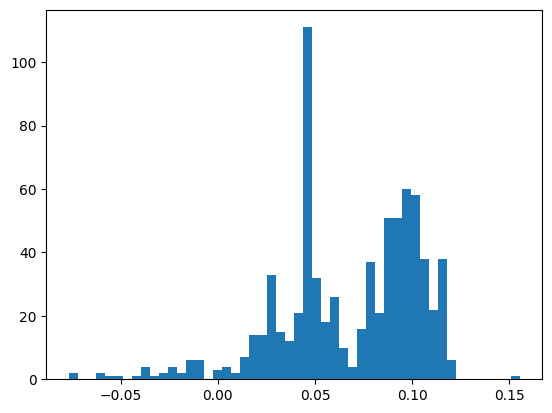

In [12]:
correlation_selector = cvtda.classification.CorrelationSelector(threshold = 0.05)

train_features = correlation_selector.fit_transform(train_features, train_labels)
test_features = correlation_selector.transform(test_features)

correlation_selector.hist()

train_features.shape, test_features.shape

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.2986, 'TOP-2 Accuracy': 0.4889, 'TOP-3 Accuracy': 0.6141, 'TOP-4 Accuracy': 0.7118, 'TOP-5 Accuracy': 0.787, 'TOP-6 Accuracy': 0.8516, 'TOP-7 Accuracy': 0.8983, 'TOP-8 Accuracy': 0.9403, 'TOP-9 Accuracy': 0.9757, 'AUC-ROC': 0.7452987555555555, 'Precision': 0.2935890696192027, 'Recall': 0.2986, 'F1-score': 0.2940812204908828}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.3476, 'TOP-2 Accuracy': 0.5377, 'TOP-3 Accuracy': 0.6544, 'TOP-4 Accuracy': 0.7414, 'TOP-5 Accuracy': 0.8152, 'TOP-6 Accuracy': 0.871, 'TOP-7 Accuracy': 0.9165, 'TOP-8 Accuracy': 0.9521, 'TOP-9 Accuracy': 0.9788, 'AUC-ROC': 0.7751111055555553, 'Precision': 0.3402152815839444, 'Recall': 0.3476, 'F1-score': 0.34150417173544584}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x0000023CE05FCE50>
Input to LazyLinear: 481
Parameters

100%|██████████| 25/25 [00:38<00:00,  1.56s/it, loss=1.07e+5, val_acc=0.348]


{'classifier': 'NNClassifier', 'Accuracy': 0.348, 'TOP-2 Accuracy': 0.5373, 'TOP-3 Accuracy': 0.6563, 'TOP-4 Accuracy': 0.7471, 'TOP-5 Accuracy': 0.8117, 'TOP-6 Accuracy': 0.8693, 'TOP-7 Accuracy': 0.9141, 'TOP-8 Accuracy': 0.9544, 'TOP-9 Accuracy': 0.9774, 'AUC-ROC': 0.7648214000000001, 'Precision': 0.340329757268122, 'Recall': 0.348, 'F1-score': 0.3360065004003073}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.3374, 'TOP-2 Accuracy': 0.5326, 'TOP-3 Accuracy': 0.6593, 'TOP-4 Accuracy': 0.7505, 'TOP-5 Accuracy': 0.8211, 'TOP-6 Accuracy': 0.8807, 'TOP-7 Accuracy': 0.925, 'TOP-8 Accuracy': 0.9636, 'TOP-9 Accuracy': 0.9841, 'AUC-ROC': 0.7781631888888888, 'Precision': 0.3267790489991012, 'Recall': 0.33740000000000003, 'F1-score': 0.32687426235651074}
Fitting <catboost.core.CatBoostClassifier object at 0x0000023D2EB7FDF0>
Learning rate set to 0.

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.2986,0.4889,0.6141,0.7118,0.7870,0.8516,0.8983,0.9403,0.9757,0.745299,0.293589,0.2986,0.294081
1,RandomForestClassifier,0.3476,0.5377,0.6544,0.7414,0.8152,0.8710,0.9165,0.9521,0.9788,0.775111,0.340215,0.3476,0.341504
2,NNClassifier,0.3480,0.5373,0.6563,0.7471,0.8117,0.8693,0.9141,0.9544,0.9774,0.764821,0.340330,0.3480,0.336007
3,HistGradientBoostingClassifier,0.3374,0.5326,0.6593,0.7505,0.8211,0.8807,0.9250,0.9636,0.9841,0.778163,0.326779,0.3374,0.326874
4,CatBoostClassifier,0.3941,0.5932,0.7176,0.8031,0.8665,0.9125,0.9468,0.9727,0.9908,0.819274,0.388753,0.3941,0.389940
5,XGBClassifier,0.3603,0.5577,0.6824,0.7747,0.8428,0.8963,0.9363,0.9682,0.9876,0.797496,0.354151,0.3603,0.353293


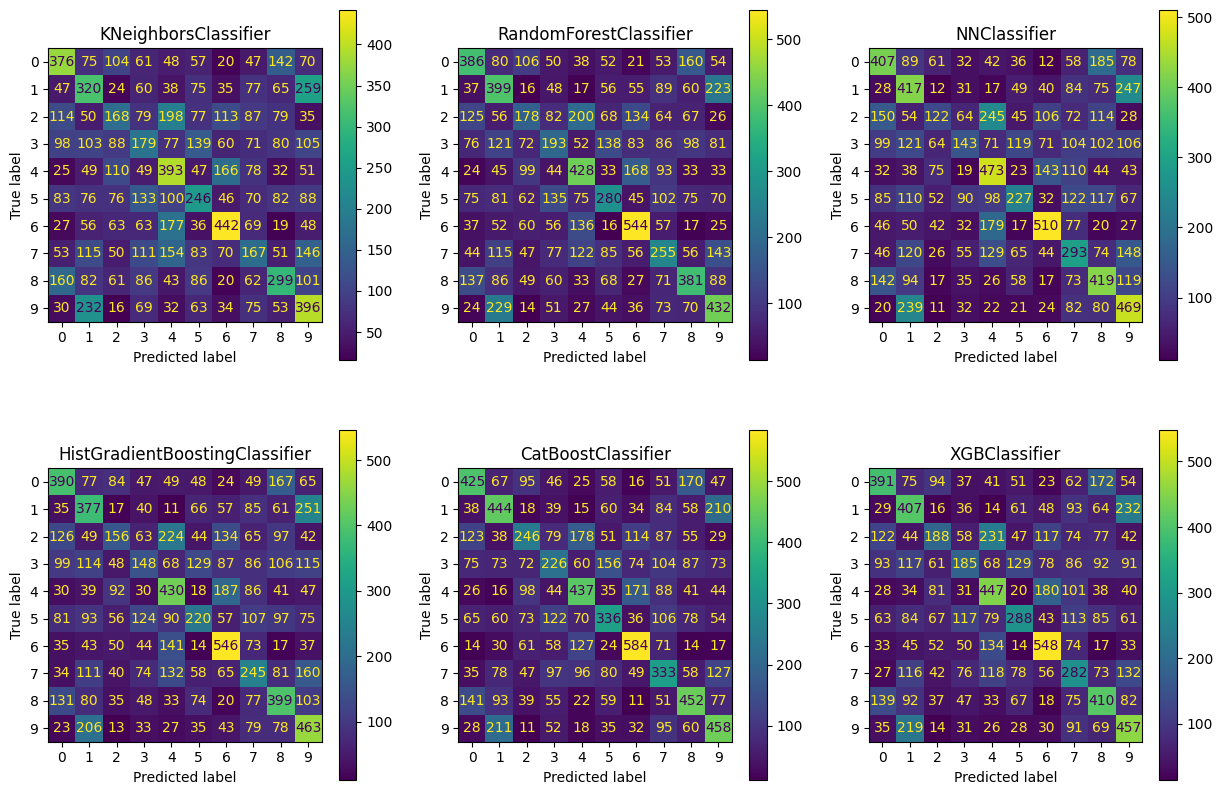

In [13]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

### PCA

In [12]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 64, random_state = 42)

train_features = pca.fit_transform(train_features)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])

test_features = pca.transform(test_features)

train_features.shape, test_features.shape

Explained variance 0.91
[0.456, 0.128, 0.056, 0.055, 0.038, 0.021, 0.015, 0.014, 0.013, 0.009, 0.009, 0.007, 0.006, 0.006, 0.005, 0.005, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


((50000, 64), (10000, 64))

In [ ]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)